In [1]:
pip install pandas numpy matplotlib seaborn scikit-learn xgboost joblib requests


[notice] A new release of pip is available: 25.0.1 -> 25.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:

# ML and EDA imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from io import StringIO

# ML tools
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score


In [3]:

import requests
import joblib

# NASA FIRMS API credentials
API_KEY = "8e38a0d0a687d17e4fa97fe161bd567b"
USERNAME = "sumn0902"


In [4]:

def get_fire_data():
    """Download fire data from NASA FIRMS API"""
    # FIRMS API parameters
    base_url = "https://firms.modaps.eosdis.nasa.gov/api/area/csv"
    source = "VIIRS_NOAA20_NRT"  # Near real-time VIIRS data
    area = "world"  # Can specify coordinates if needed
    day_range = 1  # Number of days of data to retrieve

    # Build the URL with API key
    url = f"{base_url}/{API_KEY}/{source}/{area}/{day_range}"

    try:
        response = requests.get(url, auth=(USERNAME, API_KEY))

        if response.status_code == 200:
            content = response.text.strip()

            # Check for error messages in response
            if any(content.startswith(x) for x in ["Invalid", "Error", "Failed"]):
                print(f"API Error: {content}")
                return None

            # Try to read as CSV
            try:
                data = pd.read_csv(StringIO(content))
                if data.empty:
                    print("Warning: Received empty dataframe")
                return data
            except pd.errors.ParserError as e:
                print(f"CSV Parsing Error: {e}")
                return None
        else:
            print(f"API Request Failed. Status: {response.status_code}")
            print(f"Response: {response.text[:200]}...")  # Show first 200 chars of error
            return None

    except Exception as e:
        print(f"Network/API Error: {e}")
        return None




In [5]:
def preprocess_data(data):
    """Clean and prepare the fire data for modeling"""
    if data is None or data.empty:
        return None

    # 1. Create fire risk target variable
    if 'bright_ti4' in data.columns:
        print("Creating fire_risk based on brightness temperature")
        data['brightness_temp_c'] = data['bright_ti4'] - 273.15
        bins = [-np.inf, 50, 60, 70, 80, np.inf]
        labels = [0, 1, 2, 3, 4]
        data['fire_risk'] = pd.cut(data['brightness_temp_c'], bins=bins, labels=labels)

    # 2. Handle date features
    if 'acq_date' in data.columns:
        data['acq_date'] = pd.to_datetime(data['acq_date'])
        data['day_of_year'] = data['acq_date'].dt.dayofyear

    # 3. Convert confidence to numerical
    if 'confidence' in data.columns:
        if data['confidence'].dtype == 'object':
            # Try to convert to float first
            try:
                data['confidence'] = pd.to_numeric(data['confidence'], errors='raise')
            except:
                # If conversion fails, map categorical values
                conf_map = {v: i for i, v in enumerate(data['confidence'].unique())}
                data['confidence'] = data['confidence'].map(conf_map)

    # 4. Select features and ensure numerical
    features = ['latitude', 'longitude', 'bright_ti4', 'bright_ti5',
               'frp', 'day_of_year', 'confidence', 'fire_risk']
    available_features = [f for f in features if f in data.columns]

    processed_data = data[available_features].dropna()

    # Final check - convert all to numeric
    for col in processed_data.columns:
        if processed_data[col].dtype == 'object':
            processed_data[col] = pd.to_numeric(processed_data[col], errors='coerce')

    return processed_data.dropna()



In [6]:
def evaluate_model(model, X_test, y_test, model_name):
    """Evaluate model performance and plot results"""
    y_pred = model.predict(X_test)
    
    # Classification report
    print(f"\n{model_name} Performance:")
    print(classification_report(y_test, y_pred))
    
    # Confusion matrix
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"{model_name} Confusion Matrix")
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    return {
        'model': model_name,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }



In [23]:
def train_models(data):
    """Train multiple machine learning models on fire data"""
    if data is None or 'fire_risk' not in data.columns:
        print("No valid data for modeling")
        return None

    # Prepare features and target
    X = data.drop('fire_risk', axis=1)
    y = data['fire_risk'].astype(int)  # Ensure numeric

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.6, random_state=42, stratify=y)

    # Scale numerical features
    numerical_cols = X_train.select_dtypes(include=['number']).columns
    scaler = StandardScaler()
    X_train_scaled = X_train.copy()
    X_test_scaled = X_test.copy()
    
    X_train_scaled[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
    X_test_scaled[numerical_cols] = scaler.transform(X_test[numerical_cols])

    # Initialize results storage
    results = []
    models = {}

    # 1. Logistic Regression
    print("\nTraining Logistic Regression...")
    log_reg = LogisticRegression(
        multi_class='multinomial',
        solver='lbfgs',
        max_iter=1000,
        random_state=42
    )
    log_reg.fit(X_train_scaled, y_train)
    models['logistic_regression'] = log_reg
    results.append(evaluate_model(log_reg, X_test_scaled, y_test, "Logistic Regression"))

    # 2. Random Forest
    print("\nTraining Random Forest...")
    rf = RandomForestClassifier(
        n_estimators=200,
        max_depth=10,
        min_samples_split=5,
        random_state=42,
        n_jobs=-1
    )
    rf.fit(X_train, y_train)  # RF doesn't need scaled features
    models['random_forest'] = rf
    results.append(evaluate_model(rf, X_test, y_test, "Random Forest"))

    # 3. XGBoost
    print("\nTraining XGBoost...")
    xgb = XGBClassifier(
        objective='multi:softmax',
        num_class=len(y.unique()),
        n_estimators=200,
        max_depth=6,
        learning_rate=0.1,
        random_state=42
    )
    xgb.fit(X_train, y_train)  # XGBoost doesn't need scaled features
    models['xgboost'] = xgb
    results.append(evaluate_model(xgb, X_test, y_test, "XGBoost"))

    # Compare model performances
    results_df = pd.DataFrame(results)
    print("\nModel Comparison:")
    print(results_df)

    # Plot feature importances for tree-based models
    for model_name in ['random_forest', 'xgboost']:
        plt.figure(figsize=(10, 6))
        if model_name == 'random_forest':
            importances = models[model_name].feature_importances_
        else:
            importances = models[model_name].feature_importances_
            
        pd.Series(importances, index=X.columns).sort_values().plot(kind='barh')
        plt.title(f"{model_name.replace('_', ' ').title()} Feature Importance")
        plt.show()

    return models, scaler, results_df




Successfully retrieved fire data:
Shape: (11856, 14)
Columns: ['latitude', 'longitude', 'bright_ti4', 'scan', 'track', 'acq_date', 'acq_time', 'satellite', 'instrument', 'confidence', 'version', 'bright_ti5', 'frp', 'daynight']

First 5 rows:
   latitude  longitude  bright_ti4  scan  track    acq_date  acq_time  \
0  66.99291  135.30544      334.04  0.64   0.72  2025-04-28         1   
1  66.99817  135.31160      336.53  0.64   0.72  2025-04-28         1   
2  67.08842  135.25212      327.85  0.63   0.72  2025-04-28         1   
3  67.09064  135.25096      339.20  0.63   0.72  2025-04-28         1   
4  67.09607  135.27985      340.77  0.63   0.72  2025-04-28         1   

  satellite instrument confidence version  bright_ti5   frp daynight  
0       N20      VIIRS          n  2.0NRT      276.65  6.99        D  
1       N20      VIIRS          n  2.0NRT      276.44  6.99        D  
2       N20      VIIRS          n  2.0NRT      278.69  7.44        D  
3       N20      VIIRS          n

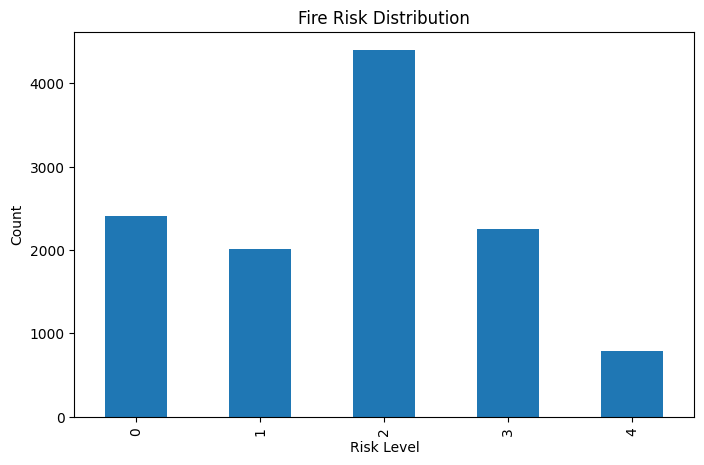

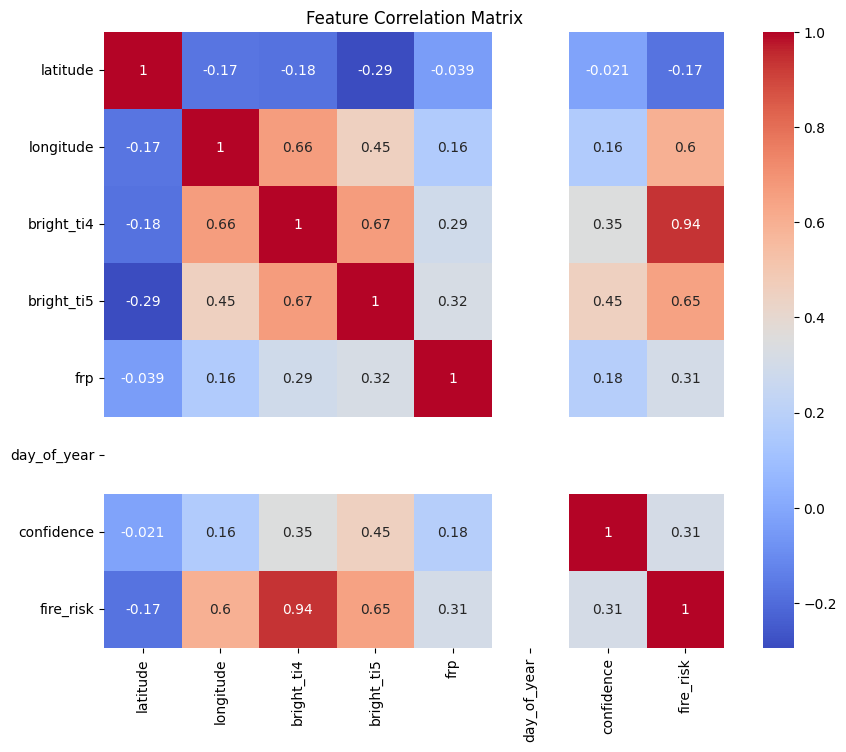


Training Logistic Regression...

Logistic Regression Performance:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      1445
           1       0.94      0.93      0.94      1208
           2       0.94      0.98      0.96      2640
           3       0.93      0.94      0.94      1351
           4       1.00      0.83      0.91       470

    accuracy                           0.95      7114
   macro avg       0.96      0.93      0.95      7114
weighted avg       0.96      0.95      0.95      7114



c:\Users\hp\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


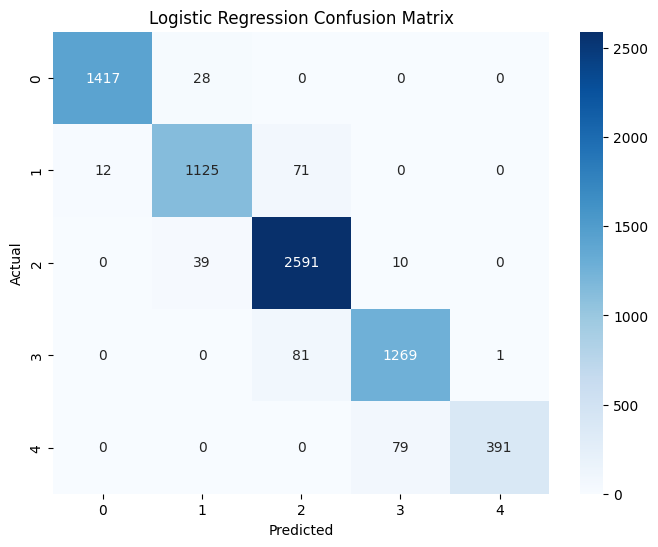


Training Random Forest...

Random Forest Performance:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1445
           1       1.00      1.00      1.00      1208
           2       1.00      1.00      1.00      2640
           3       1.00      1.00      1.00      1351
           4       1.00      1.00      1.00       470

    accuracy                           1.00      7114
   macro avg       1.00      1.00      1.00      7114
weighted avg       1.00      1.00      1.00      7114



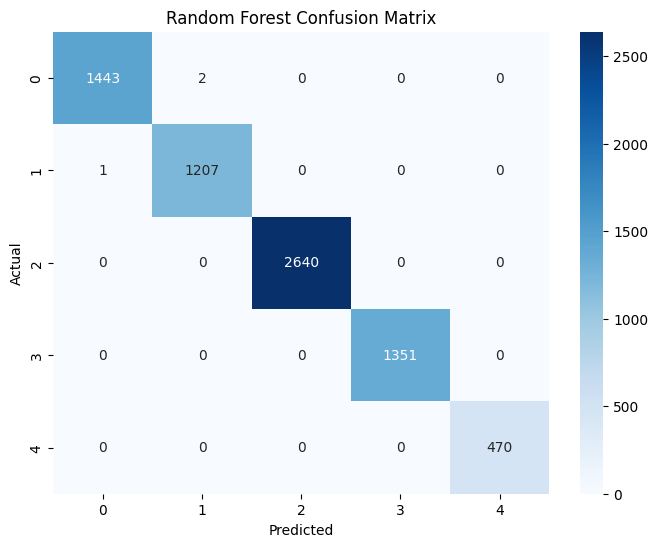


Training XGBoost...

XGBoost Performance:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1445
           1       0.99      0.99      0.99      1208
           2       1.00      1.00      1.00      2640
           3       0.99      0.99      0.99      1351
           4       0.98      0.99      0.98       470

    accuracy                           0.99      7114
   macro avg       0.99      0.99      0.99      7114
weighted avg       0.99      0.99      0.99      7114



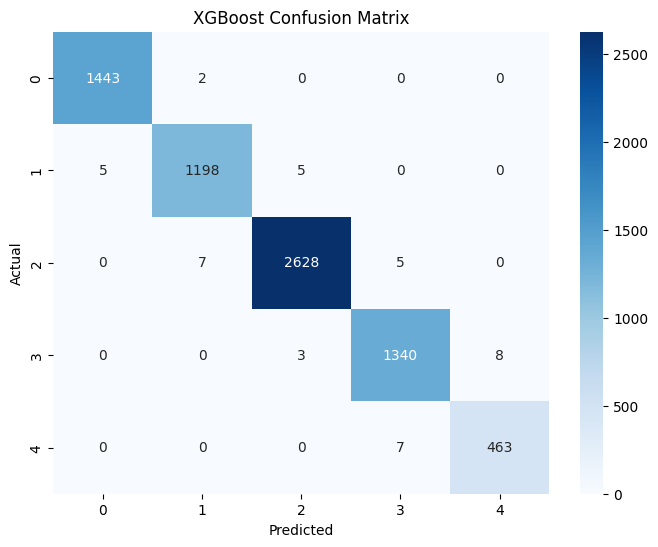


Model Comparison:
                 model  accuracy  precision    recall        f1
0  Logistic Regression  0.954878   0.955571  0.954878  0.954584
1        Random Forest  0.999578   0.999578  0.999578  0.999578
2              XGBoost  0.994096   0.994098  0.994096  0.994097


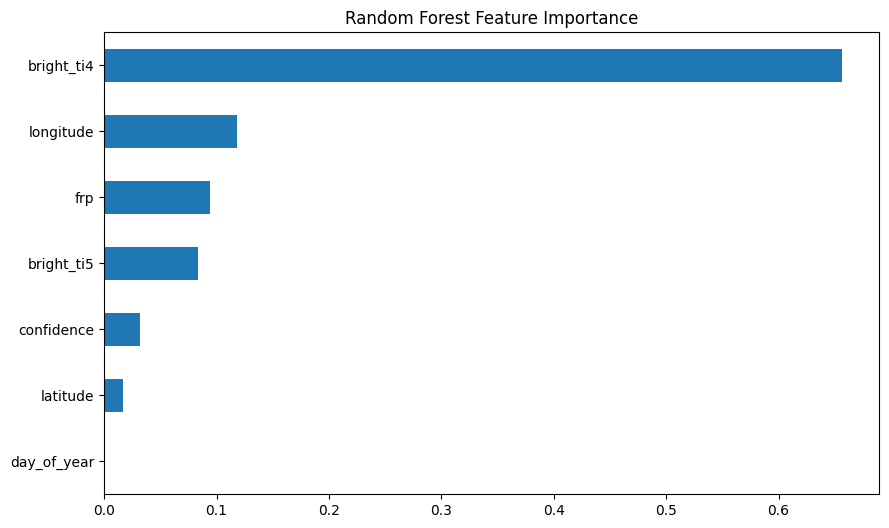

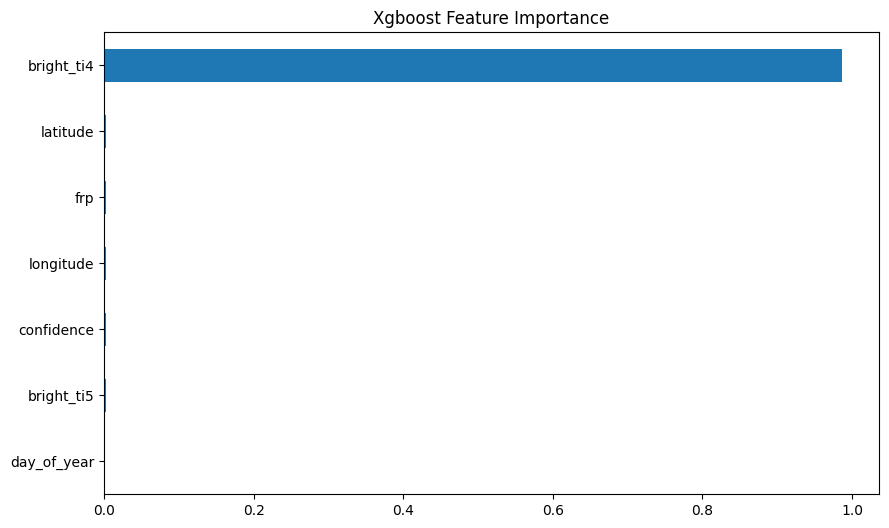


Models saved successfully!
Model comparison results saved.


In [24]:
# Main execution
if __name__ == "__main__":
    print("Downloading fire data from NASA FIRMS API...")
    fire_data = get_fire_data()

    if fire_data is not None and not fire_data.empty:
        print("\nSuccessfully retrieved fire data:")
        print(f"Shape: {fire_data.shape}")
        print(f"Columns: {list(fire_data.columns)}")
        print("\nFirst 5 rows:")
        print(fire_data.head())

        # Preprocess data
        processed_data = preprocess_data(fire_data)

        if processed_data is not None and not processed_data.empty:
            print("\nProcessed data for modeling:")
            print(f"Shape: {processed_data.shape}")
            print(processed_data.head())

            # Visualize fire risk distribution
            plt.figure(figsize=(8, 5))
            processed_data['fire_risk'].value_counts().sort_index().plot(kind='bar')
            plt.title("Fire Risk Distribution")
            plt.xlabel("Risk Level")
            plt.ylabel("Count")
            plt.show()

            # Correlation matrix
            plt.figure(figsize=(10, 8))
            sns.heatmap(processed_data.corr(), annot=True, cmap='coolwarm')
            plt.title("Feature Correlation Matrix")
            plt.show()

            # Train models
            models, scaler, results = train_models(processed_data)

            if models is not None:
                # Save models and scaler
                joblib.dump(models, 'fire_risk_models.pkl')
                joblib.dump(scaler, 'fire_risk_scaler.pkl')
                print("\nModels saved successfully!")
                
                # Save results
                results.to_csv('model_performance_comparison.csv', index=False)
                print("Model comparison results saved.")
        else:
            print("\nFailed to preprocess data for modeling")
    else:
        print("\nFailed to retrieve fire data. Please check:")
        print("- Your API key and username")
        print("- API service status")
        print("- Network connection")